# Music Lyric Mashup


Our goal for this project was to create new song lyrics based on four very different genres of music: rap, country, psychedelic rock, and musicals. We created four different text files of individual artists: NF, Morgan Wallen, The Beatles, and Phineas and Ferb. We based our code on an existing poetry generator (https://www.kaggle.com/code/paultimothymooney/poetry-generator-rnn-markov/notebook)

#To Run the Code
Press the "Run Cell" button for each cell. Start at the beginning of "Installs" under this "To Run the Code" and keep running each consecutive cell and finish once you run "Download audio files:" in "MIDI" from "Music Generation".


## Installs
First we need to make sure we have all the packages we need:

In [ ]:
pip install pronouncing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.3/939.3 kB 14.2 MB/s eta 0:00:00
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6251 sha256=b238c0cacfc94970290d778abfa0883b8ca0164cf976f262bee60ea439c818ae
  Stored in directory: /root/.cache/pip/wheels/05/f6/1d/599c67da1fa48c086d8c49e8fc6bd5f05bc9fa66fb04bed5db
Successfully built pronouncing
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.6.0
    Uninstalling importlib-metadata-6.6.0:
      Successfully uninstalled importlib-metadata-6.6.0


In [ ]:
pip install markovify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 6.1 MB/s eta 0:00:00
  Created wheel for markovify: filename=markovify-0.9.4-py3-none-any.whl size=18625 sha256=f277ae43945b052bc2cb58a1743b987b52862a40971c13e2a59fa08b110e2818
  Stored in directory: /root/.cache/pip/wheels/ca/8c/c5/41413e24c484f883a100c63ca7b3b0362b7c6f6eb6d7c9cc7f
Successfully built markovify


In [ ]:
import pronouncing
import markovify
import re
import random
import numpy as np
import os
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense

## Read Input Files

In [ ]:
def split_lyrics_file(text_file):
	text = open(text_file, encoding='utf-8').read()
	text = text.split("\n")
	while "" in text:
		text.remove("")
	return text

## Recurrent Neural Network (https://keras.io/layers/recurrent/#lstm)

Here we use Recurrent Neural Networks and Markov chains to generate new lyrics in the style of the input text. The Markovify functions (Markov Chains) are used to build new sentences based off word probabilities, then the Recurrent Neural Networks (Keras) are used to predict the properties of the next line of the poem (number of syllables, rhyme scheme), such that an appropriate new sentence can be selected from the sentences that were generated from the Markov Chain.

A sequential model (https://keras.io/guides/sequential_model/) is used since we only have one input and one output. Sequential models work best for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

In [ ]:
def create_network(depth):
	model = Sequential()
	model.add(LSTM(4, input_shape=(2, 2), return_sequences=True))
	for i in range(depth):
		model.add(LSTM(8, return_sequences=True))
	model.add(LSTM(2, return_sequences=True))
	model.summary()
	model.compile(optimizer='rmsprop',
              loss='mse')
	if artist + ".rap" in os.listdir(".") and train_mode == False:
		model.load_weights(str(artist + ".rap"))
		print("loading saved network: " + str(artist) + ".rap")
	return model

Markov Chain (https://github.com/jsvine/markovify)

Markovify is a simple, extensible Markov chain generator. It is easy to use, and we are able to tell it exactly what to do.

A Markov chain is a stochastic model describing a sequence of possible events only reliant on the probabilites based on the state attained in the previous event. This allows us to create a Markov model that can determine the probability of certain words or phrases being used in the context of our lyrics.

In [ ]:
def markov(text_file):
	read = open(text_file, "r", encoding='utf-8').read()
	text_model = markovify.NewlineText(read)
	return text_model

## Data Preprocessing
 We need to count the number of syllables in each line and get rhyming words:


In [ ]:
def syllables(line):
	count = 0
	for word in line.split(" "):
		vowels = 'aeiouy'
		word = word.lower().strip(".:;?!")
		if word[0] in vowels:
			count +=1
		for index in range(1,len(word)):
			if word[index] in vowels and word[index-1] not in vowels:
				count +=1
		if word.endswith('e'):
			count -= 1
		if word.endswith('le'):
			count+=1
		if count == 0:
			count +=1
	return count / maxsyllables

We use the pronouncing (https://pypi.org/project/pronouncing/) library to come up with words that rhyme with our list of words.

For example, we can see a list of words that rhyme with climbing using the function:


```
>>> import pronouncing
>>> pronouncing.rhymes("climbing")
['diming', 'liming', 'priming', 'rhyming', 'timing']
```





In [ ]:
def rhymeindex(lyrics):
	if str(artist) + ".rhymes" in os.listdir(".") and train_mode == False:
		print ("loading saved rhymes from " + str(artist) + ".rhymes")
		return open(str(artist) + ".rhymes", "r",encoding='utf-8').read().split("\n")
	else:
		rhyme_master_list = []
		print ("Building list of rhymes:")
		for i in lyrics:
			word = re.sub(r"\W+", '', i.split(" ")[-1]).lower()
			rhymeslist = pronouncing.rhymes(word)
			rhymeslistends = []
			for i in rhymeslist:
				rhymeslistends.append(i[-2:])
			try:
				rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
			except Exception:
				rhymescheme = word[-2:]
			rhyme_master_list.append(rhymescheme)
		rhyme_master_list = list(set(rhyme_master_list))
		reverselist = [x[::-1] for x in rhyme_master_list]
		reverselist = sorted(reverselist)
		rhymelist = [x[::-1] for x in reverselist]
		print("List of Sorted 2-Letter Rhyme Ends:")
		print(rhymelist)
		f = open(str(artist) + ".rhymes", "w", encoding='utf-8')
		f.write("\n".join(rhymelist))
		f.close()
		return rhymelist

Then we make an index of rhymes that can be used:

In [ ]:
def rhyme(line, rhyme_list):
	word = re.sub(r"\W+", '', line.split(" ")[-1]).lower()
	rhymeslist = pronouncing.rhymes(word)
	rhymeslistends = []
	for i in rhymeslist:
		rhymeslistends.append(i[-2:])
	try:
		rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
	except Exception:
		rhymescheme = word[-2:]
	try:
		float_rhyme = rhyme_list.index(rhymescheme)
		float_rhyme = float_rhyme / float(len(rhyme_list))
		return float_rhyme
	except Exception:
		float_rhyme = None
		return float_rhyme

## Generate lyrics

In [ ]:
def generate_lyrics(text_model, text_file):
	bars = []
	last_words = []
	lyriclength = len(open(text_file,encoding='utf-8').read().split("\n"))
	count = 0
	markov_model = markov(text_file)

	while len(bars) < lyriclength / 9 and count < lyriclength * 2:
		bar = markov_model.make_sentence(max_overlap_ratio = .49, tries=100)
		if type(bar) != type(None) and syllables(bar) < 1:
			def get_last_word(bar):
				last_word = bar.split(" ")[-1]
				if last_word[-1] in "!.?,":
					last_word = last_word[:-1]
				return last_word
			last_word = get_last_word(bar)
			if bar not in bars and last_words.count(last_word) < 3:
				bars.append(bar)
				last_words.append(last_word)
				count += 1
	return bars

Build dataset:

In [ ]:
def build_dataset(lines, rhyme_list):
	dataset = []
	line_list = []
	for line in lines:
		line_list = [line, syllables(line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	x_data = []
	y_data = []
	for i in range(len(dataset) - 3):
		line1 = dataset[i    ][1:]
		line2 = dataset[i + 1][1:]
		line3 = dataset[i + 2][1:]
		line4 = dataset[i + 3][1:]
		x = [line1[0], line1[1], line2[0], line2[1]]
		x = np.array(x)
		x = x.reshape(2,2)
		x_data.append(x)
		y = [line3[0], line3[1], line4[0], line4[1]]
		y = np.array(y)
		y = y.reshape(2,2)
		y_data.append(y)
	x_data = np.array(x_data)
	y_data = np.array(y_data)
	return x_data, y_data

Compose verses:

In [ ]:
def compose_rap(lines, rhyme_list, lyrics_file, model):
	rap_vectors = []
	human_lyrics = split_lyrics_file(lyrics_file)
	initial_index = random.choice(range(len(human_lyrics) - 1))
	initial_lines = human_lyrics[initial_index:initial_index + 2]
	starting_input = []
	for line in initial_lines:
		starting_input.append([syllables(line), rhyme(line, rhyme_list)])
	starting_vectors = model.predict(np.array([starting_input]).flatten().reshape(1, 2, 2))
	rap_vectors.append(starting_vectors)
	for i in range(100):
		rap_vectors.append(model.predict(np.array([rap_vectors[-1]]).flatten().reshape(1, 2, 2)))
	return rap_vectors

In [ ]:
def vectors_into_song(vectors, generated_lyrics, rhyme_list):
	print ("\n\n")
	print ("Writing verse:")
	print ("\n\n")
	def last_word_compare(rap, line2):
		penalty = 0
		for line1 in rap:
			word1 = line1.split(" ")[-1]
			word2 = line2.split(" ")[-1]
			while word1[-1] in "?!,. ":
				word1 = word1[:-1]
			while word2[-1] in "?!,. ":
				word2 = word2[:-1]
			if word1 == word2:
				penalty += 0.2
		return penalty
	def calculate_score(vector_half, syllables, rhyme, penalty):
		desired_syllables = vector_half[0]
		desired_rhyme = vector_half[1]
		desired_syllables = desired_syllables * maxsyllables
		desired_rhyme = desired_rhyme * len(rhyme_list)
		score = 1.0 - abs(float(desired_syllables) - float(syllables)) + abs(float(desired_rhyme) - float(rhyme)) - penalty
		return score
	dataset = []
	for line in generated_lyrics:
		line_list = [line, syllables(line), rhyme(line, rhyme_list)]
		dataset.append(line_list)
	rap = []
	vector_halves = []
	for vector in vectors:
		vector_halves.append(list(vector[0][0]))
		vector_halves.append(list(vector[0][1]))
	for vector in vector_halves:
		scorelist = []
		for item in dataset:
			line = item[0]
			if len(rap) != 0:
				penalty = last_word_compare(rap, line)
			else:
				penalty = 0
			total_score = calculate_score(vector, item[1], item[2], penalty)
			score_entry = [line, total_score]
			scorelist.append(score_entry)
		fixed_score_list = [0]
		for score in scorelist:
			fixed_score_list.append(float(score[1]))
		max_score = max(fixed_score_list)
		for item in scorelist:
			if item[1] == max_score:
				rap.append(item[0])
				print (str(item[0]))
				for i in dataset:
					if item[0] == i[0]:
						dataset.remove(i)
						break
				break
	return rap

## Train and Run the model

In [ ]:
def train(x_data, y_data, model):
	model.fit(np.array(x_data), np.array(y_data),
			  batch_size=2,
			  epochs=5,
			  verbose=1)
	model.save_weights(artist + ".rap")

In [ ]:
def main(depth, train_mode):
	model = create_network(depth)
	text_model = markov(text_file)
	if train_mode == True:
		bars = split_lyrics_file(text_file)
	if train_mode == False:
		bars = generate_lyrics(text_model, text_file)
	rhyme_list = rhymeindex(bars)
	if train_mode == True:
		x_data, y_data = build_dataset(bars, rhyme_list)
		train(x_data, y_data, model)
	if train_mode == False:
		vectors = compose_rap(bars, rhyme_list, text_file, model)
		rap = vectors_into_song(vectors, bars, rhyme_list)
		f = open(rap_file, "w", encoding='utf-8')
		for bar in rap:
			f.write(bar)
			f.write("\n")

## Retrieve the input files

In [ ]:
#run this to (temporarily) import our drive so we can access stuff from our project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here, we write new lyrics in the combined style of The Beatles, NF, Phineas and Ferb, and Morgan Wallen. Our input text files are all connected in our Google drive which is how we are able to retrieve and read values.

In [ ]:
filenames = ['drive/Shareddrives/AI Project/Beatles_lyrics.txt', 'drive/Shareddrives/AI Project/nf.txt', 'drive/Shareddrives/AI Project/pfsample.txt', 'drive/Shareddrives/AI Project/country.txt']
with open('combined.txt', 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                outfile.write(line)

## Understanding the data

Plot the Frequency of each of the word occurences:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def plotWordFrequency(input):
    f = open(artist_file,'r')
    words = [x for y in [l.split() for l in f.readlines()] for x in y]
    data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40]
    most_words = [x[0] for x in data]
    times_used = [int(x[1]) for x in data]
    plt.figure(figsize=(20,10))
    plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(rotation=0, fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurences:', fontsize=18)
    plt.title('Most Commonly Used Words: %s' % (artist_file), fontsize=24)
    plt.show()

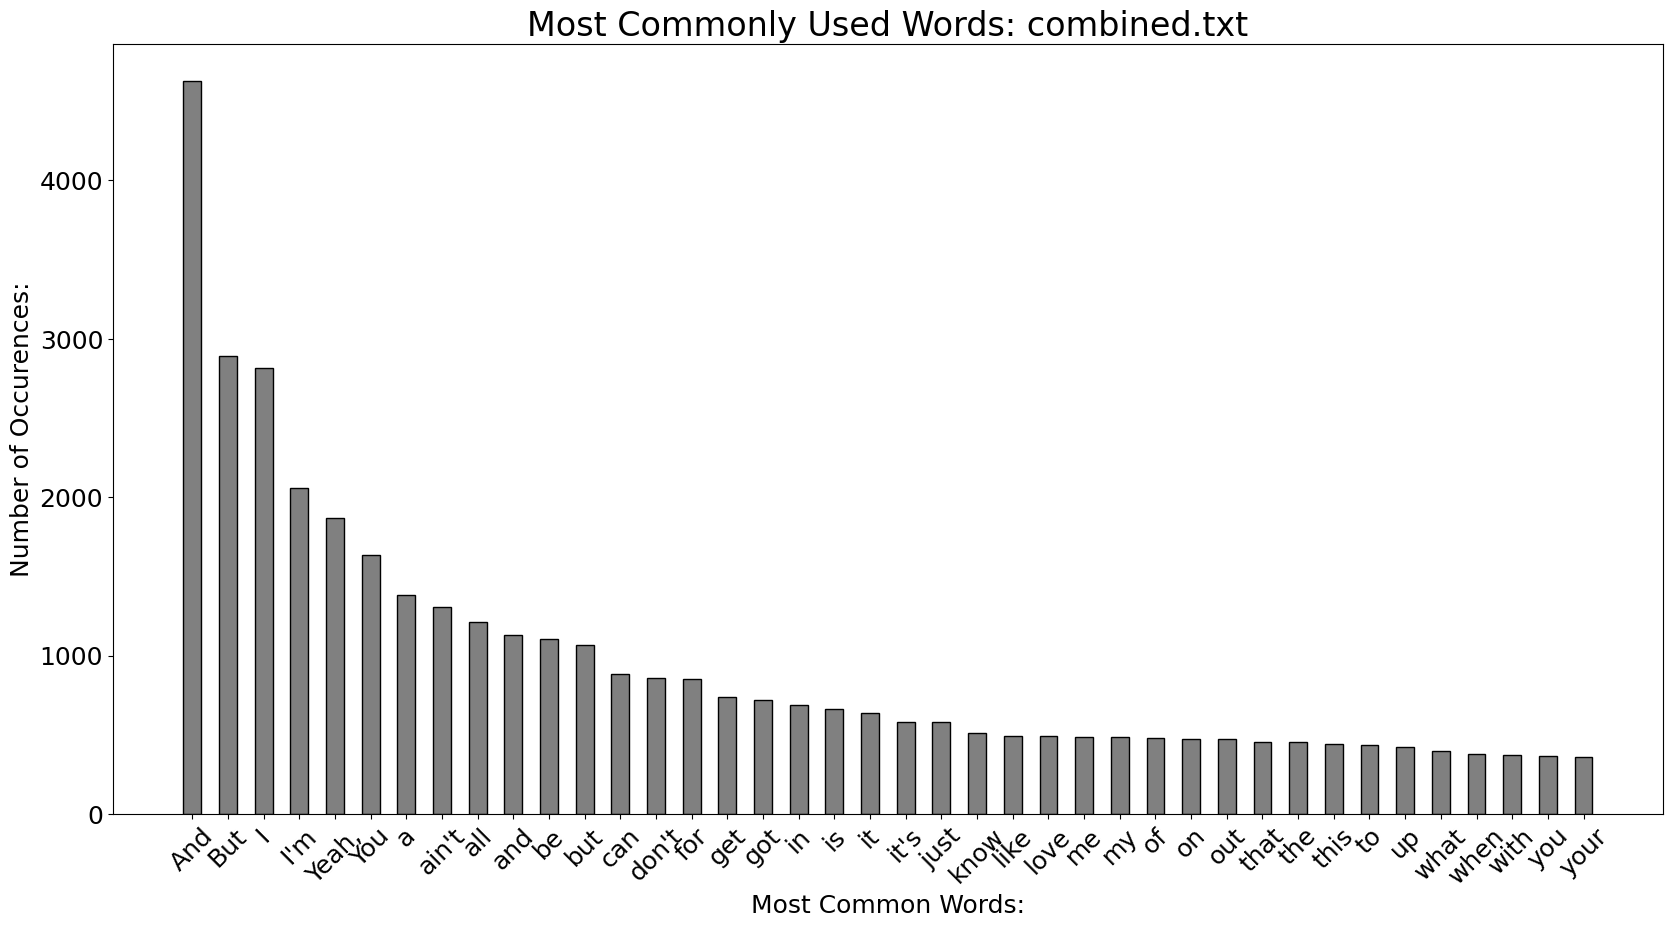

In [ ]:
artist_file = 'combined.txt'
plotWordFrequency(artist_file)

In [ ]:
with open(r"combined.txt", 'r') as fp:
    lines = len(fp.readlines())
    print('Total Number of lines:', lines)

Total Number of lines: 14329


Remove repeated lines

The combined.txt file originally had 14329 lines but a lot of that were repeated lines. After removing repeats there are 9372 lines.

In [ ]:
import hashlib

output_file_path = "newly_combined.txt"
input_file_path = "combined.txt"

input_file = open(input_file_path, "r")
output_file = open(output_file_path, "w")

completed_lines_hash = set()

for line in input_file:
  hashValue = hashlib.md5(line.rstrip().encode('utf-8')).hexdigest()
  if hashValue not in completed_lines_hash:
    output_file.write(line)
    completed_lines_hash.add(hashValue)

output_file.close()
input_file.close()

In [ ]:
with open(r"newly_combined.txt", 'r') as fp:
    lines = len(fp.readlines())
    print('Total Number of lines:', lines)

Total Number of lines: 9372


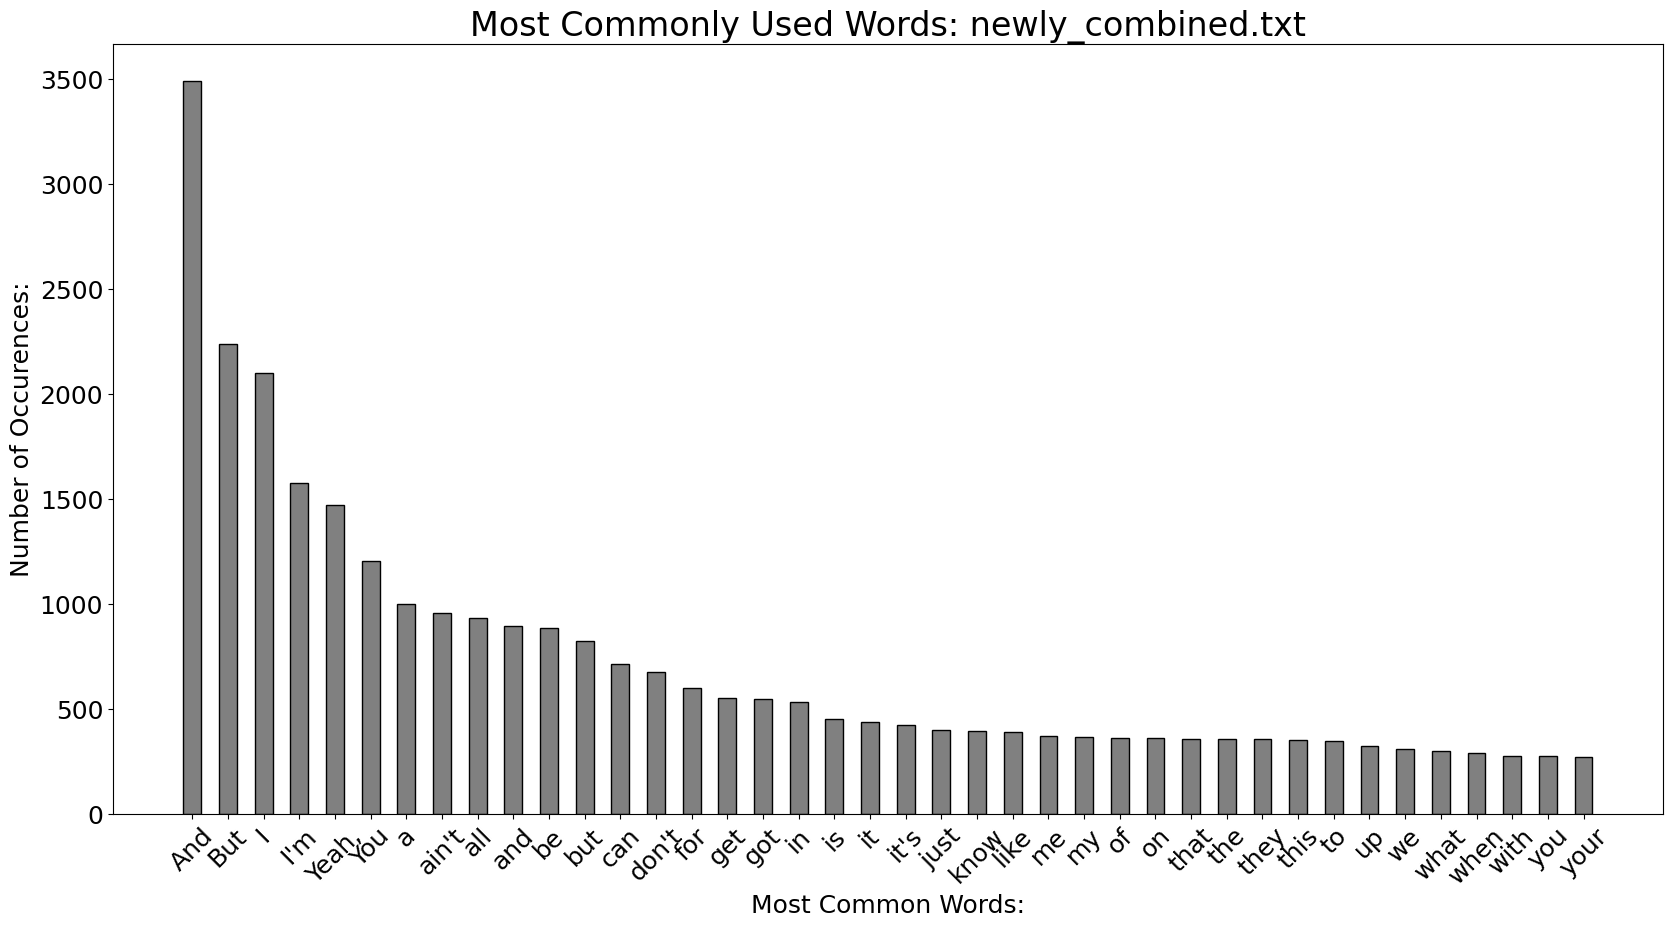

In [ ]:
artist_file = 'newly_combined.txt'
plotWordFrequency(artist_file)

In [ ]:
depth = 4

## Running the Code

Some important parameters to keep in mind:


*   maxsyllables: max number of syllables per line
*   max_overlap_ratio: how different the output should be from the original input - currently set to 0.39
* tries: how many times to try to build a line that satisifies some parameter - currently set to 100
* epochs: how many times for the NN to pass over the data


To reduce computational complexity, maximize the maxsyllables and max_overlap_ratio and minimize tries and epochs.

Computational time will increase dramatically when maxsyllables is less than 8 and when max_overlap_ratio is less than 0.5

In [ ]:
artist = "artist"
rap_file = "new_lyrics.txt"

maxsyllables = 8
text_file = "newly_combined.txt"
train_mode = True
main(depth, train_mode)
train_mode = False
main(depth, train_mode)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 2, 4)              112       
                                                                 
 lstm_7 (LSTM)               (None, 2, 8)              416       
                                                                 
 lstm_8 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_9 (LSTM)               (None, 2, 8)              544       
                                                                 
 lstm_10 (LSTM)              (None, 2, 8)              544       
                                                                 
 lstm_11 (LSTM)              (None, 2, 2)              88        
                                                                 
Total params: 2,248
Trainable params: 2,248
Non-traina

Download the new lyric file

In [ ]:
from google.colab import files
files.download(rap_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#supposedly this will undo the drive mount thing
from google.colab import drive
drive.flush_and_unmount()

# Music Generation

We created musical piano notes using a Recurent Neural Network (RNN) and tensorflow. (https://www.tensorflow.org/tutorials/audio/music_generation). This was more of an exploration of how MIDI files work since we had a completed lyric file and wanted to have a soundrack. This is more of an exploration and did not result in a majorly calculated musical file.

## Installs

In [ ]:
#first we have to install some stuff to get MIDI working. I'm not really sure what MIDI is but it's a music-y computer-y thing
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

In [ ]:
!pip install midiutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54567 sha256=244957c11c9c6506b72f312bc872939028433e73c10d1f178ffe88ae8e019a6a
  Stored in directory: /root/.cache/pip/wheels/af/43/4a/00b5e4f2fe5e2cd6e92b461995a3a97a2cebb30ab5783501b0
Successfully built midiutil


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

## MIDI

In [ ]:
#I'm not sure what this thing does but apparently it's important
seed = 30
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
#This downloads a data set of midi files
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [ ]:
#getting and parsing a sample file. Not sure what the purpose of this is either
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print(len(filenames))
sample_file = filenames[1]
#This makes a Pretty Midi object. I'm not sure what that is either but it probably does something important
#pm = pretty_midi.PrettyMIDI(sample_file)

1282


You will use three variables to represent a note when training the model: pitch, step and duration. The pitch is the perceptual quality of the sound as a MIDI note number. The step is the time elapsed from the previous note or start of the track. The duration is how long the note will be playing in seconds and is the difference between the note end and note start times.

Extract the notes from the sample MIDI file.

In [ ]:
#MIDI to notes function. This will have some use when we train our dataset
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
#This function takes in notes and converts them into a playable MIDI file.
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

Create the training dataset

Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.




In [ ]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 43182


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

Create and train the model

The model will have three outputs, one for each note variable. For step and duration, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.



In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile( loss=loss, optimizer=optimizer)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_23 (LSTM)                 (None, 128)          67584       ['input_6[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_23[0][0]']                
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_23[0][0]']                
                                                                                            

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/10
674/674 [==============================] - 44s 49ms/step - loss: 0.3390 - duration_loss: 0.0957 - pitch_loss: 4.1126 - step_loss: 0.0377
Epoch 2/10
674/674 [==============================] - 34s 51ms/step - loss: 0.3263 - duration_loss: 0.0914 - pitch_loss: 3.9715 - step_loss: 0.0362
Epoch 3/10
674/674 [==============================] - 33s 48ms/step - loss: 0.3211 - duration_loss: 0.0906 - pitch_loss: 3.8978 - step_loss: 0.0357
Epoch 4/10
674/674 [==============================] - 36s 54ms/step - loss: 0.3176 - duration_loss: 0.0890 - pitch_loss: 3.8745 - step_loss: 0.0348
Epoch 5/10
674/674 [==============================] - 35s 52ms/step - loss: 0.3149 - duration_loss: 0.0880 - pitch_loss: 3.8639 - step_loss: 0.0337
Epoch 6/10
674/674 [==============================] - 33s 50ms/step - loss: 0.3126 - duration_loss: 0.0869 - pitch_loss: 3.8542 - step_loss: 0.0330
Epoch 7/10
674/674 [==============================] - 33s 49ms/step - loss: 0.3101 - duration_loss: 0.0852 - pit

Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated. You can find more details on temperature in Text generation with an RNN.

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.5
num_predictions = 120

raw_notes = midi_to_notes(sample_file)

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 25ms/step


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Download audio files

In [ ]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>